# **Ground Cover Change Model**



**Authors:** Martin Garcia-Fry, Osamu Murao, Bruno Adriano, and Shunichi Koshimura.

**Content Editors:** Martin Garcia-Fry  


**Reference(s):** M. Garcia-Fry et al. (2022). Land Use Microsimulation Model for Livelihood Diversification after the 2010 Merapi Volcano Eruptions. Transp. Res. Part D: Transp. and Environ. 104(103189). https://doi.org/10.1016/j.trd.2022.103189

*

The GCC model is a land use land cover classification model trained on automatically supervised labels to monitor post-disaster recovery through ground cover change. Practical applications of this model bridge multiple areas of study in monitoring and evaluating spatially-explicit phenomena.

We welcome users to apply the model's framework in disaster-recurrent regional areas of interest. Open access ground cover change datasets are made available through our Earth Engine repository (see links below). The purpose of the GCC model is to update training datasets with high-quality labels for real-time emergency classifications. Moreover, we encourage open access, regionally-consistent, and multitemporal metric datasets to increment the number of high-quality training units for regional land cover classifications.

We look forward to seeing implementations of the model in disaster recurrent areas to reduce risk, monitor post-disaster investments, and retrofit pre-disaster recovery plans.

Contact: globalgroundcoverchange@gmail.com




---
Data Links:

* Access input data and documentation [HERE](https://drive.google.com/drive/folders/1QNAOlBLWR-7ohyhBdzbA-DCeK4doqgSG?usp=sharing)

* Visualize our mapping products via Earth Engine [HERE](https://code.earthengine.google.com/90c1c77df694646e7d3bd33281565b48)

* Download Earth Engine Sentinel-2 images [HERE](https://code.earthengine.google.com/2b35f4c73ff89c53fd3fd20e91230435)






---
# I. Install Dependencies

In [ ]:
%pip install geopandas rasterio rasterstats shapely
%pip install folium earthengine-api
%pip install scikit-learn
%pip install treeinterpreter
%pip install pandas

In [ ]:
from os import path as op
import pickle
from google.colab import files

import geopandas as gpd
import pandas as pd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti
from skimage import img_as_ubyte

Connect to Google Drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import os
# IMPORTANT
# 1. Download these files: GGCC_model.ipynb, training_data.geojson, and reference files.
# 2. Upload the files to your google drive using the same folder names.

mydrive = '/content/drive/My Drive'
colab = '/content/drive/My Drive/Colab Notebooks/Global Ground Cover Change model'
print(os.listdir(mydrive))

# list the current working directory
print(os.getcwd())

# make a data folder in your Colab Notebook directory if it doesn't exist
data_folder = os.path.join(colab,'data')
os.path.isdir(data_folder)
if (not os.path.isdir(data_folder)):
  os.mkdir(data_folder)
# list the contents
print(os.listdir(colab))

['Colab Notebooks', 'Authors']
/content
['data']


In [ ]:
# Establish the route to input/output files.
my_root_dir = "/content/drive/My Drive/Colab Notebooks/Global Ground Cover Change model/data"
my_output_dir = "/content/drive/My Drive/Colab Notebooks/Global Ground Cover Change model/data/Output Files"

# II. Upload The Training Dataset

In [ ]:
#sorted training dataset with highest reliability levels on top.
training_output = '/content/drive/My Drive/Colab Notebooks/Global Ground Cover Change model/data/training_data.geojson'
training_data = gpd.read_file(training_output)
#Upload an area of interest using a polygon shape in geojson format.
polygon = '/content/drive/My Drive/Colab Notebooks/Global Ground Cover Change model/data/aoi.geojson'
aoi = gpd.read_file(polygon)
# make a bounding box and centroid for mapping
bbox = aoi.total_bounds
center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid
#print data frame
training_data.shape
training_data.head()

,# N,classCode,LCP_Band,B1,B2,B3,B4,B5,B6,B8A,...,NIR_SWIR_2,SWIR_1_SWIR_2,RS2,GNDVI (F),SAVI (F),BN (F),Reliability Level,North,East,geometry
0,70,1,36,0.103508,0.107830,0.153940,0.222003,0.253280,0.270493,0.350653,...,0.107295,0.157795,-0.120258,-0.181046,0.179904,-0.529623,3,-6.889678,111.520950,POINT (111.52095 -6.88968)
1,69,1,36,0.098214,0.094611,0.138907,0.171313,0.215596,0.279234,0.366715,...,0.209747,0.203435,-0.166086,-0.104461,0.282365,-0.589830,3,-6.889678,111.520950,POINT (111.52095 -6.88968)
2,65,1,36,0.077361,0.124520,0.190246,0.274244,0.285004,0.344430,0.409372,...,0.202520,0.175649,0.005056,-0.180839,0.171248,-0.533539,3,-6.888956,111.520900,POINT (111.52090 -6.88896)
3,61,1,36,0.077475,0.099007,0.154509,0.207376,0.221950,0.319847,0.449017,...,0.324415,0.230346,-0.049649,-0.146088,0.313441,-0.638676,3,-6.888774,111.520880,POINT (111.52088 -6.88877)
4,96,1,37,0.059083,0.065902,0.092936,0.113770,0.131243,0.165071,0.187771,...,0.011517,0.053818,-0.234555,-0.100790,0.138485,-0.480418,3,-7.054047,107.744736,POINT (107.74474 -7.05405)


In [ ]:
#Verify data shape
training_data.shape

(103103, 25)

# III. Download satellite images from Google Earth Engine.


In [ ]:
# If not on Colab you'll need install the earth-engine Python API
#!pip install earthengine-api

# Athenticate to your GEE account.
!earthengine authenticate

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=z7a8FgdnQXJLQ1xjKC1PqKhP7UU8CyK3F-kQhDvC6xY&tc=wejghl3HS1gsMY9eoydIhIvwsekXbyUB-kFacivaAGk&cc=-kcJnlb9qCJ4uKZopNvxl00h8egL7Nt7bfC9LmrH3Z0

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk6fyGusGGFIgLEDOlp8NtNo0_Jrz21J3pRcX42T8ms4c0xVhY5tkuY

Successfully saved authorization token.


In [ ]:
# Earth Engine Python API
import ee
ee.Initialize()

In [ ]:
# From GEE
#training_vectors.total_bounds.tolist()
aoi = ee.Geometry.Rectangle(training_data.total_bounds.tolist())
band_sel = ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12')

sentinel_scenes = ee.ImageCollection("COPERNICUS/S2")\
    .filterBounds(aoi)\
    .filterDate('2019-01-01', '2019-12-31')\
    .select(band_sel)

scenes = sentinel_scenes.getInfo()
[print(scene['id']) for scene in scenes["features"]]

sentinel_mosaic = sentinel_scenes.mean().rename(band_sel)

sentinel_mosaic.getInfo()

COPERNICUS/S2/20190101T023109_20190101T024615_T49LFL
COPERNICUS/S2/20190101T023109_20190101T024615_T49MFM
COPERNICUS/S2/20190101T023109_20190101T024615_T49MFN
COPERNICUS/S2/20190102T025111_20190102T030543_T48LYR
COPERNICUS/S2/20190102T025111_20190102T030543_T48LZR
COPERNICUS/S2/20190102T025111_20190102T030543_T48MYS
COPERNICUS/S2/20190102T025111_20190102T030543_T48MYT
COPERNICUS/S2/20190102T025111_20190102T030543_T48MZS
COPERNICUS/S2/20190102T025111_20190102T030543_T48MZT
COPERNICUS/S2/20190102T025111_20190102T030543_T48MZU
COPERNICUS/S2/20190102T025111_20190102T030543_T49LBL
COPERNICUS/S2/20190102T025111_20190102T030543_T49LCL
COPERNICUS/S2/20190102T025111_20190102T030543_T49LDL
COPERNICUS/S2/20190102T025111_20190102T030543_T49MBM
COPERNICUS/S2/20190102T025111_20190102T030543_T49MBN
COPERNICUS/S2/20190102T025111_20190102T030543_T49MBP
COPERNICUS/S2/20190102T025111_20190102T030543_T49MCM
COPERNICUS/S2/20190102T025111_20190102T030543_T49MCN
COPERNICUS/S2/20190102T025111_20190102T030543_

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B6',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min

**Import Satellite Image to Google Drive**

Access this GEE script and extract the full set of images [HERE](https://code.earthengine.google.com/?scriptPath=users%2Fmartingarciafry%2Fgf%3AGGCC_Shared_Folder%2FIDN_Java%2FIDN_Sentinel-2_2016-2021)

# IV. Classification Labels

In [ ]:
# find all unique values of training data names to use as classes
classes = np.unique(training_data.classCode)
classes

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# create a dictionary of class names and integers.
class_names = {1:'Dense Short Vegetation',
               2:'Open Tree Cover',
               3:'Dense Tree Cover',
               4:'Wetland Tree Cover',
               5:'Built Up',
               6:'Water',
               7:'Cropland Cultivation',
               8:'Cropland Senescence',
               9:'Cropland Growing'}

class_dict = dict(zip(classes, range(len(class_names))))
class_dict
lc_classes = dict(zip(class_names.values(), range(len(class_dict))))
lc_classes
keys = ['Dense Short Vegetation', 'Open Tree Cover', 'Dense Tree Cover', 'Wetland Tree Cover', 'Built Up', 'Water', 'Cropland Cultivation', 'Cropland Senescence', 'Cropland Growing']
values = [1, 2, 3, 4, 5, 6, 7, 8, 9]
lc_classes.update(zip(keys, values))
lc_classes.items()
lc_classes

{'Dense Short Vegetation': 1,
 'Open Tree Cover': 2,
 'Dense Tree Cover': 3,
 'Wetland Tree Cover': 4,
 'Built Up': 5,
 'Water': 6,
 'Cropland Cultivation': 7,
 'Cropland Senescence': 8,
 'Cropland Growing': 9}

In [ ]:
# Append class values to a list
y_raw =[]
for i in training_data.classCode:
  [i for i in lc_classes.values()]
  y_raw.append(i)
print(y_raw)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
# Divide signatures and labels, respectively.
X = np.array(training_data)
y = np.array(y_raw)
(X.shape, y.shape)

((103103, 25), (103103,))

In [ ]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
print (X_test.shape)
print (y_test.shape)

(20621, 25)
(20621,)


In [ ]:
#sort test data to access Level 3 units first.
arr1inds = X_test[:,21].argsort()
X_test_sorted = X_test[arr1inds[::-1]]
y_test_sorted = y_test[arr1inds[::-1]]

# Check the order of levels and their corresponding labels.
print (X_test_sorted[:,21])
print (y_test_sorted)

[3 3 3 ... 2 2 2]
[5 1 8 ... 1 1 8]


In [ ]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{1: 3.278366062354523e-05,
 2: 5.8668231152830744e-05,
 3: 6.833868653044489e-05,
 4: 0.001075268817204301,
 5: 5.2664840952180324e-05,
 6: 0.0005509641873278236,
 7: 0.00013808340237503452,
 8: 0.00013700506918755994,
 9: 0.0002151462994836489}

# V. Test Hyperparameter Settings

In [ ]:
columns = np.r_[X[:,3:21]]

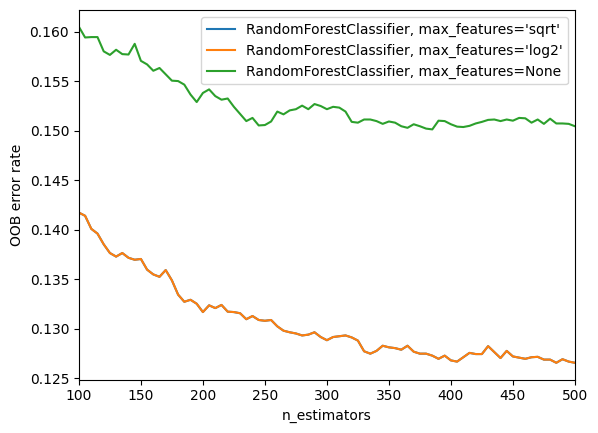

In [ ]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

columns, y = make_classification(
    n_samples=25000,
    n_features=18,
    n_clusters_per_class=1,
    n_informative=12,
    n_classes=9,
    random_state=RANDOM_STATE,
)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(columns, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

>0.1 0.936 (0.005)
>0.2 0.944 (0.005)
>0.3 0.949 (0.004)
>0.4 0.950 (0.004)
>0.5 0.952 (0.004)
>0.6 0.954 (0.004)
>0.7 0.954 (0.004)
>0.8 0.955 (0.004)
>0.9 0.955 (0.004)
>1.0 0.957 (0.003)


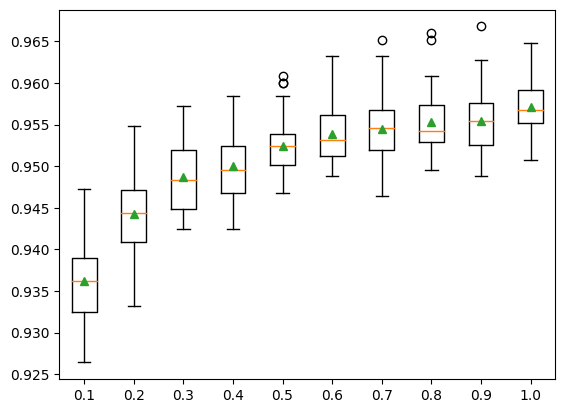

In [ ]:
# Bootstrap sample size (max_samples)
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

#get the dataset
def get_dataset():
	columns, y = make_classification(n_samples=25000, n_features=18, n_informative=12, n_redundant=6, random_state=3)
	return columns, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore ratios from 10% to 100% in 10% increments
	for i in arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		# set max_samples=None to use 100%
		if i == 1.0:
			i = None
		models[key] = RandomForestClassifier(max_samples=i)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

^Bootstrap Sample Size (max_samples=)^

In [ ]:
# tree depth effect
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
	columns, y = make_classification(n_samples=25000, n_features=18, n_informative=12, n_redundant=6, random_state=3)
	return columns, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# consider tree depths from 1 to 33 and None=full
	depths = [i for i in range(1,25)] + [None]
	for n in depths:
		models[str(n)] = RandomForestClassifier(max_depth=n)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# Number of samples per node (min_sample_split)
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
	columns, y = make_classification(n_samples=15000, n_features=18, n_informative=12, n_redundant=5, random_state=3)
	return columns, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 25
	for i in range(1,18):
		models[str(i)] = RandomForestClassifier(min_samples_split=i)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, columns, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, columns, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

^Tree depth (Max_Depth=)^

Final Parameters: Grid Search Approach

In [ ]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(
        columns, y, test_size=0.20, random_state=0)

clf = RandomForestClassifier(class_weight=class_weight_dict,
    n_estimators=391,
    max_features='log2',
    max_samples=0.8,
    bootstrap=True,
    n_jobs=-1,
    verbose=1,
    random_state=0)
param_grid = {'max_depth': [17, 19],
              'min_samples_split': [10, 15, 20, 22, 23, 25]}
grid_search = GridSearchCV(clf, param_grid, cv=3)

grid_search.fit(X_train, y_train)
grid_search.best_estimator_

In [ ]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'max_depth': 19, 'min_samples_split': 10}
Best cross-validation score: 0.53


# VI. Random Forest Model Calibration

In [ ]:
# Classifier Parameters
clf = RandomForestClassifier(
    n_estimators=391,
    class_weight=class_weight_dict,
    max_depth=17,
    min_samples_split=22,
    max_samples=0.8,
    max_features='log2',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    verbose=1,
    random_state=0)

In [ ]:
#Fit the model with training data: Use columns with spectral signatures and band combinations only.

#columns = np.r_[X_train[:,3:21]] #unmark to train model with a partitioned dataset and test data accuracy.
#clf.fit(columns,y_train)

columns = np.r_[X[:,3:21]] #unmark to train model with entire dataset.
clf.fit(columns,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 391 out of 391 | elapsed:  2.7min finished


RandomForestClassifier(class_weight={1: 3.278366062354523e-05,
                                     2: 5.8668231152830744e-05,
                                     3: 6.833868653044489e-05,
                                     4: 0.001075268817204301,
                                     5: 5.2664840952180324e-05,
                                     6: 0.0005509641873278236,
                                     7: 0.00013808340237503452,
                                     8: 0.00013700506918755994,
                                     9: 0.0002151462994836489},
                       max_depth=17, max_features='log2', max_samples=0.8,
                       min_samples_split=22, n_estimators=391, n_jobs=-1,
                       oob_score=True, random_state=0, verbose=1)

# VII. Test the Model

Accuracy 01 - Reliable

In [ ]:
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

# Entire dataset
columns = np.r_[X[:,3:21]]

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
lst_accu_stratified = []

for train_index, test_index in skf.split(columns, y):
    x_train_fold, x_test_fold = columns[train_index], columns[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    clf.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(clf.score(x_test_fold, y_test_fold))

# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

Accuracy 02 - Somewhat reliable

In [ ]:
# predict on X_test to evaluate the model
columns_test = np.r_[X_test_sorted[:,3:21]]
preds = clf.predict(columns_test)
cm = confusion_matrix(y_test_sorted, preds, labels=labels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 391 out of 391 | elapsed:    2.9s finished


Confusion Matrix

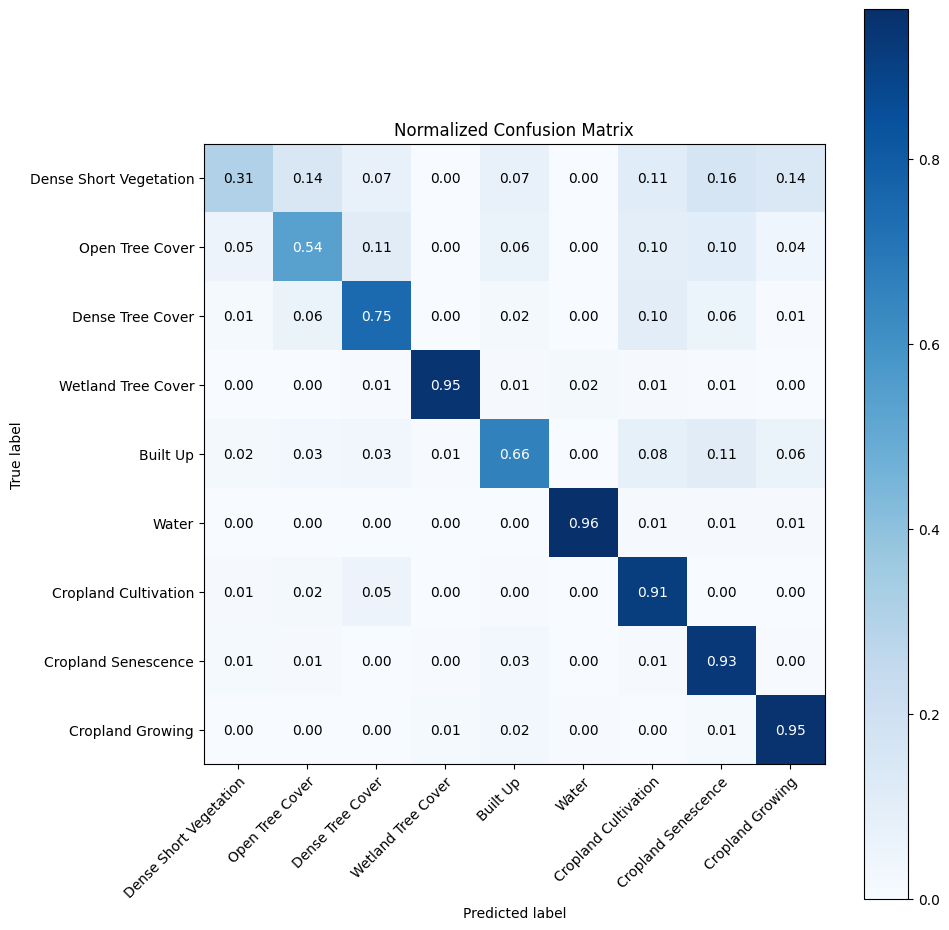

In [ ]:
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=lc_classes, yticklabels=lc_classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test_sorted, preds)))
print(f"RF test data accuracy: {metrics.accuracy_score(y_test_sorted, preds):.3f}")
print('standard deviation:', np.std(preds))

Root Mean Squared Error: 3.055195966651932
RF test data accuracy: 0.605
standard deviation: 2.706287709090203


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(clf, columns_test, preds)
print("Cross-validation scores:\n{}".format(
    cross_val_score(clf, columns_test, preds, cv=kfold)))
print("Average cross-validation score: {:.2f}".format(scores.mean()), (np.std(scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 358 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 388 out of 391 | elapsed:   20.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 391 out of 391 | elapsed:   21.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 391 out of 391 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 391 out of 391 | elapsed:   21.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Don

Cross-validation scores:
[0.78157576 0.79752667 0.78467507 0.78419011 0.78103783]
Average cross-validation score: 0.78 0.006737477310677188


[Parallel(n_jobs=2)]: Done 391 out of 391 | elapsed:    0.3s finished


In [ ]:
# Predictive Accuracy
from sklearn import metrics
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

spearman = spearmanr(y_test_sorted, preds)
pearson = pearsonr(y_test_sorted, preds)
print(f'Out-of-bag R-2 score estimate: {clf.oob_score_:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: 0.498
Test data Spearman correlation: 0.401
Test data Pearson correlation: 0.471


In [ ]:
# Accuracy Report
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test_sorted, preds))
print('Accuracy:', accuracy_score(y_test_sorted, preds))
print('standard deviation:', np.std(preds))

              precision    recall  f1-score   support

           1       0.85      0.31      0.45      6101
           2       0.60      0.54      0.57      3409
           3       0.69      0.75      0.72      2927
           4       0.73      0.95      0.82       186
           5       0.77      0.66      0.71      3798
           6       0.95      0.96      0.96       363
           7       0.45      0.91      0.60      1448
           8       0.41      0.93      0.57      1460
           9       0.42      0.95      0.58       929

    accuracy                           0.60     20621
   macro avg       0.65      0.77      0.66     20621
weighted avg       0.69      0.60      0.59     20621

Accuracy: 0.6048203287910383
standard deviation: 2.706287709090203


In [ ]:
# We will use permutations to evaluate predictors' contributions and multicollinearity using test data (n repeat=10 times).
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, columns_test, y_test_sorted,
                            n_repeats=10,
                            random_state=0)

band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B8A', 'B11', 'Q1', 'Q2', 'Q3', 'NDVI', 'NIR_SWIR_2', 'SWIR_1_2', 'RS2', 'GR', 'SAVI', 'BN']

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{band_names[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 391 out of 391 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 391 out of 391 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 391 out of 391 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      |

SWIR_1_20.124 +/- 0.002
B11     0.038 +/- 0.001
RS2     0.026 +/- 0.002
B3      0.023 +/- 0.001
NIR_SWIR_20.022 +/- 0.001
GR      0.021 +/- 0.001
NDVI    0.015 +/- 0.001
B2      0.013 +/- 0.000
B5      0.012 +/- 0.001
B1      0.009 +/- 0.001
B4      0.009 +/- 0.001
BN      0.008 +/- 0.001
B6      0.007 +/- 0.001
B8A     0.004 +/- 0.001
SAVI    0.004 +/- 0.001


[Parallel(n_jobs=2)]: Done 391 out of 391 | elapsed:    2.0s finished


In [ ]:
# Get Mean Decrease in Impurity (MDI)
importances = list(clf.feature_importances_)

band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B8A', 'B11', 'Q1', 'Q2', 'Q3', 'NDVI', 'NIR_SWIR_2', 'SWIR_1_2', 'RS2', 'GR', 'SAVI', 'BN']

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(band_names, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
print(np.sum(importances[0:8]))

Variable: NDVI                 Importance: 0.11
Variable: SAVI                 Importance: 0.09
Variable: BN                   Importance: 0.09
Variable: B11                  Importance: 0.08
Variable: SWIR_1_2             Importance: 0.08
Variable: RS2                  Importance: 0.07
Variable: GR                   Importance: 0.07
Variable: B4                   Importance: 0.06
Variable: B6                   Importance: 0.06
Variable: B8A                  Importance: 0.06
Variable: NIR_SWIR_2           Importance: 0.06
Variable: B2                   Importance: 0.05
Variable: B3                   Importance: 0.05
Variable: B1                   Importance: 0.04
Variable: B5                   Importance: 0.04
Variable: Q1                   Importance: 0.0
Variable: Q2                   Importance: 0.0
Variable: Q3                   Importance: 0.0
0.43294995028289707


In [ ]:
# Model Bias, Variance, and Total Error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.datasets import make_blobs

columns = np.r_[X[:,3:21]]
X = columns
y = y
X, y = make_blobs(centers=2, n_samples=1000, random_state=0, shuffle=True)

clf = RandomForestClassifier(
    n_estimators=391,
    max_depth=17,
    min_samples_split=22,
    max_features='log2',
    max_samples=0.8,
    bootstrap=True,
    n_jobs=-1,
    verbose=1,
    random_state=0)

# Bootstraps
n_repeat = 100
stratified_shuffle_split = StratifiedShuffleSplit(test_size=0.20, n_splits=n_repeat)

# Store sample predictions
y_all_pred = [[] for _ in range(len(y))]

# Train classifier on each bootstrap and score predictions
for i, (train_index, test_index) in enumerate(stratified_shuffle_split.split(X, y)):
    # Train and predict
    clf.fit(X[train_index], y[train_index])
    y_pred = clf.predict(X[test_index])

    # Store predictions
    for i,index in enumerate(test_index):
        y_all_pred[index].append(y_pred[i])

# Compute bias, variance, error
bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat
            for i,x in enumerate(y_all_pred)])
var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
           for i,x in enumerate(y_all_pred)])
error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat
            for i,x in enumerate(y_all_pred)])

print("Bias squared: %.2f, Variance: %.2f, Total error: %.2f" % (bias_sq, var, error))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 391 out of 391 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 391 out of 391 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 391 out of 391 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 task

Bias squared: 7.47, Variance: 0.50, Total error: 7.97


[Parallel(n_jobs=-1)]: Done 391 out of 391 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 391 out of 391 | elapsed:    0.1s finished


In [ ]:
# predict again with the tree interpreter to see how much each band contributes to the classification
sample = 100
prediction, bias, contributions = ti.predict(clf, columns_test[:sample])
c = np.sum(contributions, axis=0)

In [ ]:
# plot the contributions
band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B8A', 'B11', 'Q1', 'Q2', 'Q3', 'NDVI', 'NIR_SWIR_2', 'SWIR_1_2', 'RS2', 'GR', 'SAVI', 'BN']
gdf = gpd.GeoDataFrame(c, columns=lc_classes, index=band_names)
gdf.style.background_gradient(cmap='viridis')


,Dense Short Vegetation,Open Tree Cover,Dense Tree Cover,Wetland Tree Cover,Built Up,Water,Cropland Cultivation,Cropland Senescence,Cropland Growing
B1,0.072357,-0.093328,0.116693,-0.328568,0.628783,-0.063039,0.081840,-0.057799,-0.356940
B2,0.199424,-0.192207,-0.127553,-0.344061,0.164668,-0.070503,0.016581,0.326675,0.026976
B3,0.182971,0.135949,-0.197460,-0.333188,0.174279,-0.021740,-0.079966,0.237179,-0.098024
B4,0.146708,0.038654,-0.052408,-0.310667,0.253611,-0.020737,-0.541706,0.385346,0.101199
B5,0.360321,0.279177,-0.188555,-0.399994,0.155956,-0.191462,-0.167717,0.153240,-0.000966
B6,0.406399,0.232886,0.248524,-0.210875,0.417572,-1.773892,0.192090,0.463244,0.024051
B8A,0.421215,0.263582,0.320367,-0.258112,0.357842,-1.741810,0.171652,0.386382,0.078881
B11,0.854898,0.332686,0.071424,-0.941845,0.504805,-1.149787,-0.124137,0.442920,0.009037
Q1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Q2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# VIII. Save the Trained Model

Note: Save your model or open the pickle file stored in our shared Google Drive folder/Output Files folder

In [ ]:
# (optional) save the trained model as python pickle file

# insert [country_ID] to define the model's coverage area.
model_name = op.join(my_output_dir,'GCC[IDN]Java_Model.sav')
with open(model_name, 'wb') as modelfile:
    pickle.dump(clf, modelfile)

# IX. Classification



In [ ]:
# Predictor Formulas

#Tasseled Cap Greenness
def band_index_2 (arr, a, b, c, d, e, f):
  return np.expand_dims((-0.3599*(arr[...,a]))-(0.3533*(arr[..., b]))-(0.4734*(arr[...,c]))+(0.6633*(arr[...,d]))-(0.0087*(arr[..., e]))-(0.2856*(arr[..., f])), axis=1)

#Tasseled Cap Wetness
def band_index_3 (arr, a, b, c, d, e, f):
  return np.expand_dims((0.2578*(arr[...,a]))+(0.2305*(arr[..., b]))+(0.0883*(arr[...,c]))+(0.1071*(arr[...,d]))-(0.7611*(arr[..., e]))-(0.5308*(arr[..., f])), axis=1)

#Band Combinations (NDVI, NDWI, GNDVI, burn ratio, etc.)
def band_index_4(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

#MCARI
def band_index_5(arr, a, b, c):
    return np.expand_dims(((arr[..., a] - arr[..., b])- 0.2*(arr[..., a] - arr[..., c]))*(arr[..., a] - arr[..., b]), axis=1)

#SAVI
def band_index_6(arr, a, b):
    return np.expand_dims((((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b] + 0.5))*1.5), axis=1)

#IRECI
def band_index_7(arr, a, b, c, d):
    return np.expand_dims(((arr[..., a] - arr[..., b]) / (arr[..., c] / arr[..., d])), axis=1)

#EVI
def band_index_8(arr, a, b, c):
    return np.expand_dims(2.5*((arr[..., a] - arr[..., b]) / ((arr[..., a] + 6)*(arr[..., b]-7.5)*(arr[..., c]+0.5))), axis=1)


Define the satellite image for classification

In [ ]:
raster_file = '/content/drive/My Drive/Colab Notebooks/Global Ground Cover Change model/data/2019_east_comp_4326.tif'
print(raster_file)

/content/drive/My Drive/Colab Notebooks/Global Ground Cover Change model/data/2019_east_comp_4326.tif


In [ ]:
#classification (CAUTION: DO NOT EDIT THIS CODE)
from math import floor

new_image = raster_file

# assign a name to the output image.
output_image = op.join(my_root_dir, "[IDN]201900N100E_preliminary.tif")
non = 0
src = rasterio.open(new_image, 'r')
profile = src.profile
profile.update(
    dtype=rasterio.uint8,
    count=1,
    nodata=non,
)
dst = rasterio.open(output_image, 'w', **profile)

# performs prediction on each small image patch to minimize required memory
patch_size = 500

for i in range((src.shape[0] // patch_size) + 1):
    for j in range((src.shape[1] // patch_size) + 1):
        # define the pixels to read (and write)
        window = rasterio.windows.Window(
            j * patch_size,
            i * patch_size,
            # don't read past the image bounds
            min(patch_size, src.shape[1] - j * patch_size),
            min(patch_size, src.shape[0] - i * patch_size)
        )

        data = src.read(window=window)
        # reads the image into the proper format, adding indices if necessary
        img_swp = np.moveaxis(data, 0, 2)
        img_flat = img_swp.reshape(-1, img_swp.shape[-1])

        # IMPORTANT
        # unmark predictors used for model fitting
        img_ndvi = band_index_4(img_flat, 8, 3)
        #img_ndwi_1 = band_index_4(img_flat, 8, 9)
        #img_ndwi_2 = band_index_4(img_flat, 2, 7)
        nir_swir2 = band_index_4(img_flat, 8, 10)
        swir1_2 = band_index_4(img_flat, 9, 10)
        rs_2 = band_index_4(img_flat, 3, 10)
        gndvi = band_index_4(img_flat, 2, 3)
        savi = band_index_6(img_flat, 8, 3)
        bn = band_index_4(img_flat, 1, 8)
        #ireci = band_index_7(img_flat, 6, 3, 4, 5)
        #evi = band_index_8(img_flat, 8, 3, 1)
        #ndi45 = band_index_4(img_flat, 4, 3)
        #mcari = band_index_5(img_flat, 4, 3, 2)
        #tass_gn = band_index_2(img_flat, 1, 2, 3, 8, 9, 10)
        #tass_wt = band_index_3(img_flat, 1, 2, 3, 8, 9, 10)


        # IMPORTANT: Add predictors to the list.
        img_w_ind = np.concatenate([img_flat, img_ndvi, nir_swir2, swir1_2, rs_2, gndvi, savi, bn], axis=1)

        # removes no data values, store the indices for later use
        # a later cell makes the assumption that all bands have identical no-data value arrangements
        m = np.ma.masked_invalid(img_w_ind)
        length = img_w_ind[~m.mask].shape[0]

        # IMPORTANT: insert the number of predictors (+ spectral bands).
        a = (int(floor(length/18)))*18
        to_predict = (img_w_ind[~m.mask])[0:a,].reshape(-1, img_w_ind.shape[-1])

        # predict
        if not len(to_predict):
            continue
        img_preds = clf.predict(to_predict)

        # resize to the original image dimensions
        output = np.zeros(img_flat.shape[0])

        # add the prediction back to valid pixels and fill blanks with zeros
        z = len(output[~m.mask[:,0]])
        b = output[~m.mask[:,0]].shape[0] - img_preds.shape[0]
        d = abs(b)
        img_preds = np.pad(img_preds, [(0, d)], mode='constant')

        output[~m.mask[:,0]] = img_preds[:img_preds[:z,].shape[0],].flatten()
        output = output.reshape(*img_swp.shape[:-1])

        # create final mask
        mask = (~m.mask[:,0]).reshape(*img_swp.shape[:-1])

        # write the final file
        dst.write(output.astype(rasterio.uint8), 1, window=window)
        dst.write_mask(mask, window=window)
        # write the final file
        dst.write(output.astype(rasterio.uint8), 1, window=window)
        dst.write_mask(mask, window=window)

src.close()
dst.close()

<ipython-input-16-989fcff3ace6>:13: RuntimeWarning: invalid value encountered in true_divide
  return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 391 out of 391 | elapsed:    0.3s finished
<ipython-input-16-989fcff3ace6>:13: RuntimeWarning: invalid value encountered in true_divide
  return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 391 out of 391 | elapsed:    0.3s finished
<ipython-input-16-989fcff3ace6>:13: RuntimeWarning: invalid value encountered in true_di

# X. Accuracy Assessment

In [ ]:
# Import the pre-processed classification.
naip_fn = '/content/drive/My Drive/Colab Notebooks/Global Ground Cover Change model/data/[IDN]201900N100E_preliminary.tif'

# Import validation data in shapefile format.
validation_output = '/content/drive/My Drive/Colab Notebooks/Global Ground Cover Change model/data/Validation/preliminary_3857.shp'
validation_data = gpd.read_file(validation_output)

# print data frame
validation_data.head()

,fid,label,ground_tru,north,east,geometry
0,1,Wetland,4,-8.227992,111.109209,POINT (12368620.557 -919100.329)
1,2,Water,6,-8.220034,111.108035,POINT (12368489.857 -918205.245)
2,3,Water,6,-8.214020,111.107598,POINT (12368441.266 -917528.839)
3,4,Built Up,5,-8.205830,111.106699,POINT (12368341.145 -916607.665)
4,5,Built up,5,-8.197305,111.105831,POINT (12368244.520 -915648.908)


In [ ]:
validation_data.shape

(269, 6)

In [ ]:
#Confusion Matrix
from osgeo import gdal
from osgeo import ogr
from sklearn import metrics
from numpy import std

driverTIFF = gdal.GetDriverByName('GTIff')
naip_ds = gdal.Open(naip_fn)

valid_ds = ogr.Open(validation_output)
lyr = valid_ds.GetLayer()
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())

# Attribute = 'insert' the label for ground truth values.
options = ['ATTRIBUTE=ground_tru']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
truth = target_ds.GetRasterBand(1).ReadAsArray()

# insert classified image name
pred_ds = gdal.Open('/content/drive/My Drive/Colab Notebooks/Global Ground Cover Change model/data/[IDN]201900N100E_preliminary.tif')

# Pixel-Wise Error Matrix
pred = pred_ds.GetRasterBand(1).ReadAsArray()
idx = np.nonzero(truth)
cm = metrics.confusion_matrix(truth[idx], pred[idx])
print(cm)

# Metrics
producers = ((cm.diagonal()) / cm.sum(axis=1))
users = ((cm.diagonal()) / cm.sum(axis=0))
overall = (np.sum(cm.diagonal())+47+10)/(np.sum(cm.sum(axis=1)))
print('producers:',producers)
print('users:', users)
print('Samples:', cm.sum(axis=1))
print('Overall:', overall)


[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  1  0  0  0  1  2  0]
 [ 0  7 43  3  0  0  0  3  1  0]
 [ 0  2  3 31  0  1  0  3  0  0]
 [ 0  0  0  0  2  0  1  1  0  1]
 [ 0  1  2  0  0 34  0  0  7  0]
 [ 1  0  0  0  0  0  8  0  0  1]
 [ 0  5  5  6  0  4  0 27 47 10]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
producers: [       nan 0.5        0.75438596 0.775      0.4        0.77272727
 0.8        0.25961538        nan        nan]
users: [0.         0.21052632 0.81132075 0.75609756 1.         0.87179487
 0.88888889 0.77142857 0.         0.        ]
Samples: [  0   8  57  40   5  44  10 104   0   0]
Overall: 0.7686567164179104


<ipython-input-85-1746be53d78b>:32: RuntimeWarning: invalid value encountered in true_divide
  producers = ((cm.diagonal()) / cm.sum(axis=1))


In [ ]:
#(Optional) Save the matrix as .csv file.
import csv
from osgeo import gdal
# insert 'name'
header = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Users']
confusion = op.join(my_output_dir, 'confusion_matrix.csv')

cm = metrics.confusion_matrix(truth[idx], pred[idx], normalize='true')
cm = np.column_stack((cm,users))

with open(confusion, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(cm)
    writer.writerow(producers)

In [ ]:
# Report the Results
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from numpy import std
report = classification_report(truth[idx], pred[idx])
print(report)


In [ ]:
#(Optional) Save the report as .csv file.
import csv
# insert 'name'
accuracy = op.join(my_output_dir, 'accuracy_report.csv')
report = classification_report(truth[idx], pred[idx])
with open(accuracy, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(report)
f.close()

# XI. View the Results

<Axes: >

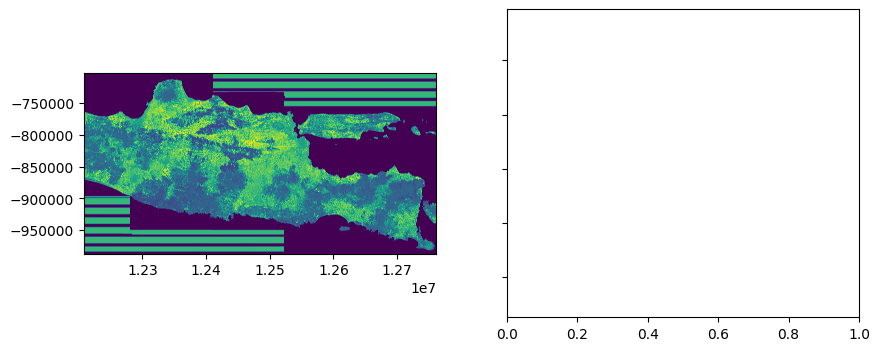

In [ ]:
# Visualize the results
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline

#insert file name
output_image = '/content/drive/My Drive/Colab Notebooks/Global Ground Cover Change model/data/[IDN]201900N100E_preliminary.tif'

def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()

# Compare side by side
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([1,2,3])
  for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band],
            in_range=(0, 3000),
            out_range=[0, 255]
        )
  s2 = s2.astype(np.uint8)
  #print(s2.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1)

# The Satellite image is too large to open with the available resources. Unmark to show raster image side by side.
#show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2)

# **END**